  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID        NAME LSAD  \
0      09      009  00212798  0500000US09009  09009   New Haven   06   
1      09      001  00212794  0500000US09001  09001   Fairfield   06   
2      09      007  00212797  0500000US09007  09007   Middlesex   06   
3      09      011  00212799  0500000US09011  09011  New London   06   
4      09      005  00212796  0500000US09005  09005  Litchfield   06   

        ALAND     AWATER                                           geometry  
0  1565688367  667081242  MULTIPOLYGON (((-72.76143 41.24233, -72.75973 ...  
1  1618651428  549293518  MULTIPOLYGON (((-73.21717 41.14391, -73.21611 ...  
2   956493754  180679140  POLYGON ((-72.75294 41.5925, -72.74284 41.5944...  
3  1722716728  276657755  POLYGON ((-72.46673 41.5839, -72.42886 41.5889...  
4  2384116952   62334525  POLYGON ((-73.51795 41.67086, -73.51678 41.687...  


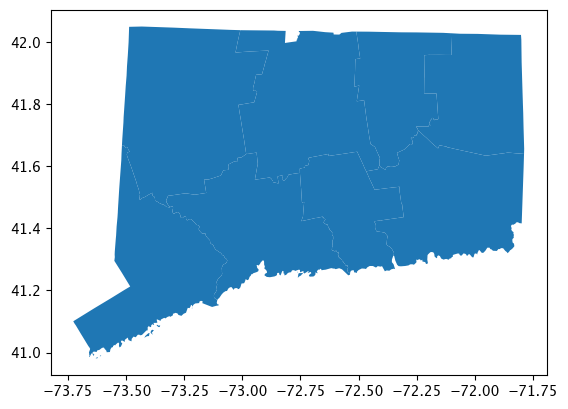

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
import warnings
import pandas as pd
import os

counties = gpd.read_file('https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_county_500k.zip')

ct_counties = counties[counties['STATEFP'] == '09']


os.makedirs('.../ct_county_shapefiles', exist_ok=True)
ct_counties.to_file('.../ct_county_shapefiles/ct_counties.shp')

ct_counties = gpd.read_file('.../ct_county_shapefiles/ct_counties.shp')


print(ct_counties.head())

ct_counties.plot()
plt.show()

# Generate Connecticut County Maps

In [46]:
ct_parameters = pd.read_csv("../New_England_Datasets/NEW ENGLAND's data (states) - CT.csv")
ct_parameters

,COUNTY,Population,Income (per capita),Education \n(high school or higher attendance rate),Health (life expectancy),Crime rate (per population)
0,FAIRFIELD,"62,508","$83,636",96.90%,82.1,0.305
1,HARTFORD,"119,674","$26,189",76.30%,79.4,0.218
2,LITCHFIELD,"8,249","$61,908",95.20%,79.2,0.052
3,MIDDLESEX,"164,759","$28,251",95.00%,80.8,0.042
4,NEW HAVEN,"135,307","$33,084",88.30%,79.2,0.299
5,NEW LONDON,"27,199","$33,888",88.00%,79.5,0.068
6,TOLLAND,"14,556","$69,283",97.60%,81.3,0.007
7,WINDHAM,"117,000","$71,581",84.40%,78.0,0.010


In [47]:
ct_parameters.columns.tolist()

['COUNTY',
 'Population',
 'Income (per capita)',
 'Education \n(high school or higher attendance rate)',
 'Health (life expectancy)',
 'Crime rate (per population)']

In [48]:
ct_counties['NAME']=ct_counties['NAME'].str.upper()


In [49]:
ct_counties['Population'] = ct_parameters['Population'].str.replace(',', '').astype(float)
ct_counties['Income'] = ct_parameters['Income (per capita)'].str.replace('$', '').str.replace(',', '').astype(float)
ct_counties['Education']=ct_parameters['Education \n(high school or higher attendance rate)'].str.replace('%', '').astype(float)
ct_counties['Health']=ct_parameters['Health (life expectancy)']
ct_counties['Crime Rate']=ct_parameters['Crime rate (per population)']

ct_counties['Income'] = pd.to_numeric(ct_counties['Income'], errors='coerce')
ct_counties['Education'] = pd.to_numeric(ct_counties['Education'], errors='coerce')
ct_counties['Health'] = pd.to_numeric(ct_counties['Health'], errors='coerce')
ct_counties['Crime Rate'] = pd.to_numeric(ct_counties['Crime Rate'], errors='coerce')
ct_counties['Population'] = pd.to_numeric(ct_counties['Population'], errors='coerce')



In [50]:
ct_counties = ct_counties.dissolve(by='NAME', aggfunc='first').reset_index()




ct_counties = ct_counties.to_crs(epsg=4326)

m = folium.Map(location=[44, -71], zoom_start=6)


# All your choropleth layers
folium.Choropleth(
    geo_data=ct_counties,
    name='Income',
    data=ct_counties,
    columns=['NAME', 'Income'],
    key_on='feature.properties.NAME',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Income per Capita ($)',
    overlay=True,
    show=True
).add_to(m)

folium.Choropleth(
    geo_data=ct_counties,
    name='Education',
    data=ct_counties,
    columns=['NAME', 'Education'],
    key_on='feature.properties.NAME',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Education (%)',
    overlay=True,
    show=False
).add_to(m)

folium.Choropleth(
    geo_data=ct_counties,
    name='Healthcare',
    data=ct_counties,
    columns=['NAME', 'Health'],
    key_on='feature.properties.NAME',
    fill_color='Purples',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Life Expectancy',
    overlay=True,
    show=False
).add_to(m)

folium.Choropleth(
    geo_data=ct_counties,
    name='Crime Rate',
    data=ct_counties,
    columns=['NAME', 'Crime Rate'],
    key_on='feature.properties.NAME',
    fill_color='Reds',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Crime Rate',
    overlay=True,
    show=False
).add_to(m)

folium.Choropleth(
    geo_data=ct_counties,
    name='Population',
    data=ct_counties,
    columns=['NAME', 'Population'],
    key_on='feature.properties.NAME',
    fill_color='Oranges',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Population',
    overlay=True,
    show=False
).add_to(m)

# Create a feature group with higher z-index for tooltips
tooltip_layer = folium.FeatureGroup(name='State Info', overlay=True, control=True, show=True)

# Add GeoJson to the feature group
folium.GeoJson(
    ct_counties,
    tooltip=folium.GeoJsonTooltip(
        fields=['NAME', 'Population', 'Income', 'Education', 'Health', 'Crime Rate'],
        aliases=['County:', 'Population:', 'Income/capita:', 'Education %:', 'Life Expectancy:', 'Crime Rate:'],
        style='background-color: white; color: black; font-size: 12px; padding: 10px;',
        sticky=False
    ),
    style_function=lambda x: {
        'fillOpacity': 0,
        'color': 'black',
        'weight': 0.5,
        'zIndex': 1000  # High z-index to stay on top
    },
    highlight_function=lambda x: {
        'weight': 2,
        'color': 'yellow'
    }
).add_to(tooltip_layer)


tooltip_layer.add_to(m)

folium.LayerControl().add_to(m)

m.save('../maps/ct_counties_map.html')